# Coherence Analyses

The notebook makes a comparison of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{E[P_{xy}]^2}{E[P_{xx}]E[P_{yy}]}$$

### Make imports and write functions

In [1]:
import scipy.signal as ss
import h5py
from IPython.display import HTML, display
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy.fft import ifft
from sklearn.utils.extmath import randomized_svd
import time

In [2]:
def loadBradyHShdf5(file,normalize='yes'):
    '''

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize=='yes':
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr

def windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the frequency domain representation of data in windows.
    """

    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap/sample_interval)
    intervals = np.arange(window_samples, total_samples+1, window_samples, dtype=int) # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples
        absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end
        
    
    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies

def normalised_windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)
    
    # win_spectra = np.absolute(win_spectra)**2 # sub for next line
    # win_spectra = win_spectra * np.conjugate(win_spectra) # absolutes square of spectra. We need this if
    # we want to use the normalised spectra to calculate welch coherence.
    # normalizer = np.sum(win_spectra, axis=0)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(np.sqrt(normalizer),(win_spectra.shape[0],1,1))
    normalizer = normalizer.transpose(2,1,0)

    normalized_spectra = win_spectra.transpose(2,1,0) / normalizer

    return normalized_spectra, frequencies

def welch_coherence(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the coherence matrix at all (or particular frequencies: yet to be implemented)
    using the welch method.
    """

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(normalizer,(normalizer.shape[0],1,1))
    normalizer = normalizer * normalizer.transpose((1,0,2))
    normalizer = normalizer.transpose(2,1,0)

    welch_numerator = np.matmul(win_spectra.transpose(2,1,0), np.conjugate(win_spectra.transpose(2,0,1)))
    welch_numerator = np.absolute(welch_numerator)**2
    coherence = np.multiply(welch_numerator,1/normalizer)

    return coherence, frequencies

def stalta_freq(data, len_lt, len_st):
    # Does stalta on data with len_lt as the length of the longtime and len_st
    # as the length of the short time
    if data.ndim == 1:
        longtime_avg = ss.correlate(np.absolute(data), np.ones(len_lt), mode = "valid")
        shorttime_avg = ss.correlate(np.absolute(data[(len_lt - len_st):]), np.ones(len_st), mode = "valid")
        stalta = (shorttime_avg * len_lt)/(longtime_avg * len_st)
    elif data.ndim == 2:
        nch, nsamples = data.shape
        stalta = np.empty((nch, nsamples - len_lt + 1), dtype=np.float64)
        longtime_stencil = np.ones(int(len_lt))
        shorttime_stencil = np.ones(int(len_st))
        for a in range(nch):
            longtime_avg = ss.correlate(np.absolute(data[a]), longtime_stencil, mode = "valid")
            shorttime_avg = ss.correlate(np.absolute(data[a, int(len_lt - len_st):]), shorttime_stencil, mode = "valid")
            stalta[a] = (shorttime_avg * len_lt)/(longtime_avg * len_st)

    return stalta

### Parameters for data and tests

In [3]:
samples_per_sec=1000
fsize=15
nsensors=200
# start_ch = 1000
# nchannels = 3000

start_ch = 3100
nchannels = 2000
# nchannels = 5100

# start_ch = 10
# nchannels = 3000

# start_ch = 5500
# nchannels = 2500

# start_ch = 100
# nchannels = 5000

win_len = 2.5
overlap = 0

subwin_width = 4096 # number of samples in each subwindow
num_subwins = 10 # number of subwindows to average over
avgwin_width = num_subwins * subwin_width # number of samples in averaging window

colors = ['#800000', '#FFD700', '#663399', '#000000', '#008B8B']

# Background noise test

In [21]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise,_= loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2,_= loadBradyHShdf5(file,normalize='no')

data_noise = np.append(data_noise,data_noise2,axis=1)

MemoryError: Unable to allocate 998. MiB for an array with shape (30000, 8721) and data type float32

: 

In [ ]:
norm_win_spectra, frequencies = normalised_windowed_spectra(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
coherence = np.absolute(welch_coherence_mat)**2

# coherence, frequencies = welch_coherence(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

In [ ]:
num_frames = coherence.shape[0]

eig_ratios = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d])
    qr_approx2 = np.sort(np.diag(np.absolute(R@R.transpose()))**2)[::-1]
    eig_ratios_qr[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))

Text(0.5, 1.0, 'Proportion of $\\lambda_1$ in sum of all eigenvalues')

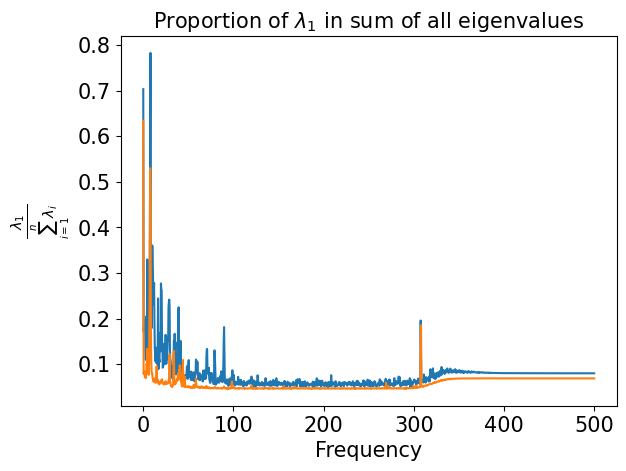

In [ ]:
plt.plot(frequencies, eig_ratios_qr, label='QR')
plt.plot(frequencies, eig_ratios, label='Original')

plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)

### Plot data

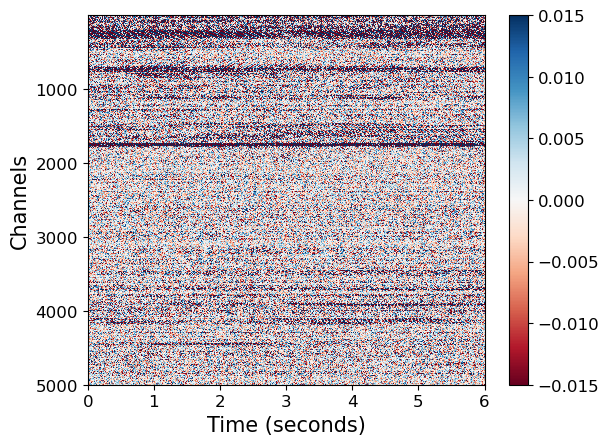

In [9]:
# pdata=np.append(data[:,24976:],data2[:,:10000],axis=1) 
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
tick_size = 12
ch_start = 1
# v_min = -np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
# v_max = np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
v_min = -0.015
v_max = 0.015

# pdata = data[3000:8000, 47240:53256]

fig2 = plt.figure()
# img2 = plt.imshow(data_noise[start_ch:nchannels+start_ch], cmap="RdBu", 
img2 = plt.imshow(data_noise[3000:8000, 47240:53256], cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none',
           extent=(0, 6, 5000, 1))
        #    extent=(0,len(data_noise[start_ch:nchannels+start_ch][0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

# Small event test

In [ ]:
# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314093648.h5"
# data,_ = loadBradyHShdf5(file,normalize='no')

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314093718.h5"
# data2,_ = loadBradyHShdf5(file,normalize='no')

# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314093748.h5"
# data3,_= loadBradyHShdf5(file,normalize='no')

# # signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)

# data = np.append(data,data2,axis=1)
# # data = np.append(data,data3[:,:10000],axis=1)
# data = np.append(data,data3,axis=1)
# samples_per_sec=1000

: 

In [4]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
data,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data2,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data3,_= loadBradyHShdf5(file,normalize='no')

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
data = np.append(data,data2,axis=1)
data = np.append(data,data3[:,:10000],axis=1)
samples_per_sec=1000

In [5]:
stalta_data = stalta_freq(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], 2000, 300)

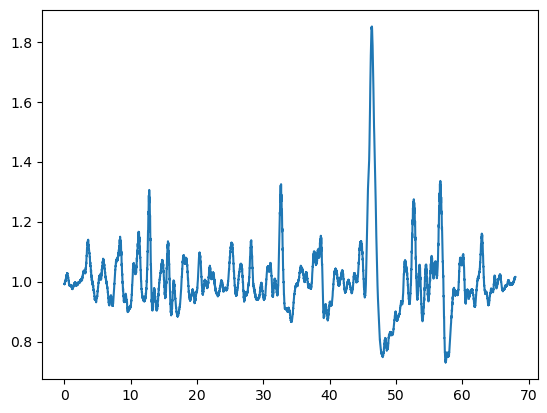

In [6]:
xax = np.array(range(stalta_data.shape[1]))/1000
plt.plot(xax, np.mean(stalta_data, axis=0))

In [7]:
t0 = time.time()
norm_win_spectra2, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
t1 = time.time()
common_time = t1-t0
welch_coherence_mat = np.matmul(norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0,2,1)))
coherence2 = np.absolute(welch_coherence_mat)**2

# coherence2, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

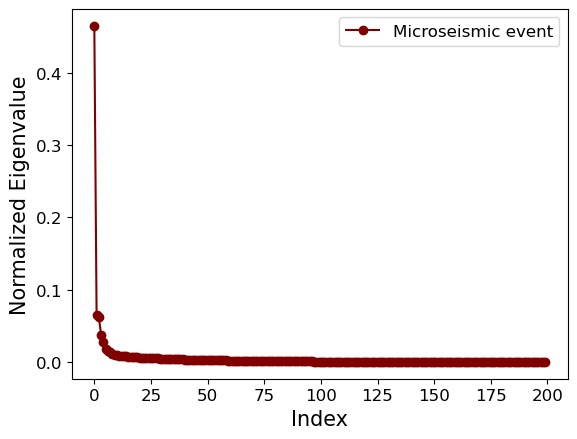

In [11]:
i = 37
tick_size = 12
# eigenvals, eigenvecs = np.linalg.eig(coherence[i])
eigenvals2, eigenvecs = np.linalg.eig(coherence2[i])
# plt.imshow(coherence[0])
# plt.colorbar()
# plt.plot(np.sort(eigenvals2/np.sum(eigenvals2))[::-1], '-o', color="darkviolet", label='Microseismic event')
# plt.plot(np.sort(eigenvals/np.sum(eigenvals))[::-1], '-*', color="goldenrod", label='Noise')

plt.plot(np.sort(eigenvals2/np.sum(eigenvals2))[::-1], '-o', color=colors[0], label='Microseismic event')
# plt.plot(np.sort(eigenvals/np.sum(eigenvals))[::-1], '-*', color=colors[1], linewidth=2, label='Noise')

# plt.yscale('log')
# plt.ylabel("Detection parameter",fontsize=fsize)
plt.ylabel("Normalized Eigenvalue",fontsize=fsize)
plt.xlabel("Index",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.text(100, 60, 'Detection parameter = ' + str(abs(eigenvals2[0]/np.sum(eigenvals2))), color = "darkviolet", horizontalalignment='center', verticalalignment='center', fontsize=fsize)
# plt.text(100, 60, 'Detection parameter = ' + str(abs(eigenvals[0]/np.sum(eigenvals))), color = "goldenrod", horizontalalignment='center', verticalalignment='center', fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

# perc95 = np.percentile(eigenvals,95)

# plt.plot([0,200], [perc95,perc95])

# eigenvals = np.sort(eigenvals)[::-1]

In [12]:
num_frames = coherence2.shape[0]

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_svd2 = np.empty(num_frames)
t0 = time.time()
welch_coherence_mat = np.matmul(norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0,2,1)))
coherence2 = np.absolute(welch_coherence_mat)**2
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
t1 = time.time()
eig_time = t1-t0 + common_time

t0 = time.time()
for d in range(num_frames):
    Q,R = np.linalg.qr(norm_win_spectra2[d])
    qr_approx2 = np.sort(np.diag(np.absolute(R@R.transpose()))**2)[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
t1 = time.time()
qr_time = t1-t0 + common_time


t0 = time.time()
for d in range(num_frames):
    U, S, Vh = np.linalg.svd(norm_win_spectra2[d])
    svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_svd2[d] = svd_approx2[0]/np.sum(np.absolute(svd_approx2))
t1 = time.time()
svd_time = t1-t0 + common_time


print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

Eigenvalue time:  91.70383524894714
QR time:  2.4749300479888916
SVD time:  13.184210538864136


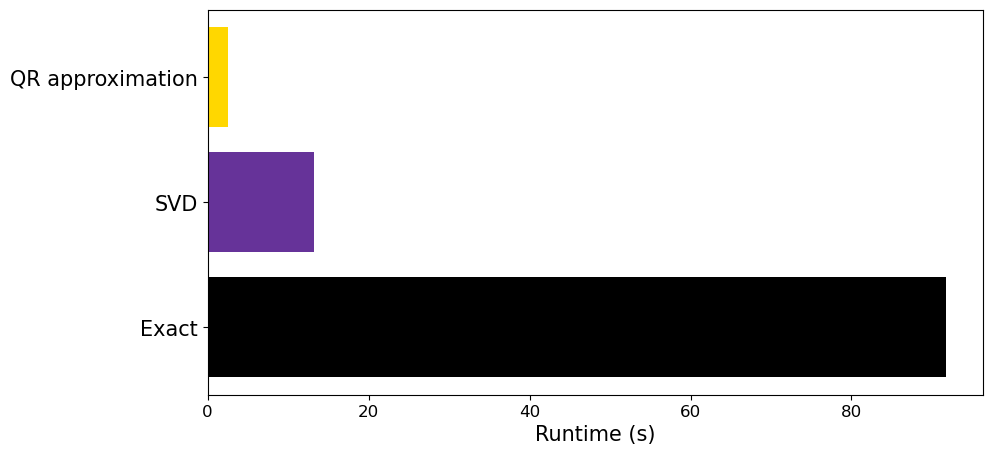

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

methods = ["Exact", "SVD", "QR approximation"]
# methods = [1, 1.2]
times = [eig_time, svd_time, qr_time]
bar_labels = ["Exact", "SVD", "QR approximation"]
# bar_colors = ['darkviolet', 'goldenrod']
# bar_colors = ['#800000', '#FFD700'] #'#FFA500']
bar_colors = [colors[3], colors[2], colors[1]]
# bar_colors = colors[2:4][::-1]

ax.barh(methods, times, label=bar_labels, color=bar_colors, height=0.8)

ax.set_xlabel('Runtime (s)', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=fsize)
# ax.set_title('Runtime')
# ax.legend(fontsize=tick_size)

plt.show()

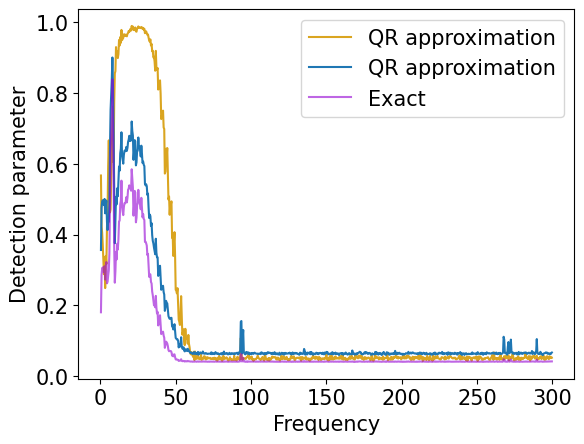

In [16]:
last_freq_index = 750

plt.plot(frequencies[1:last_freq_index], eig_ratios_qr2[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.plot(frequencies[1:last_freq_index], eig_ratios_svd2[1:last_freq_index], label='SVD approximation')
plt.plot(frequencies[1:last_freq_index], eig_ratios2[1:last_freq_index], color="darkviolet", alpha=0.6, label='Exact')
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=fsize)

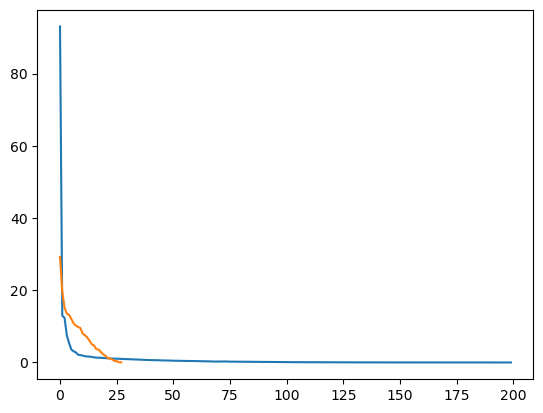

In [17]:
plt.plot(eigenvals2)
plt.plot(svd_approx2)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

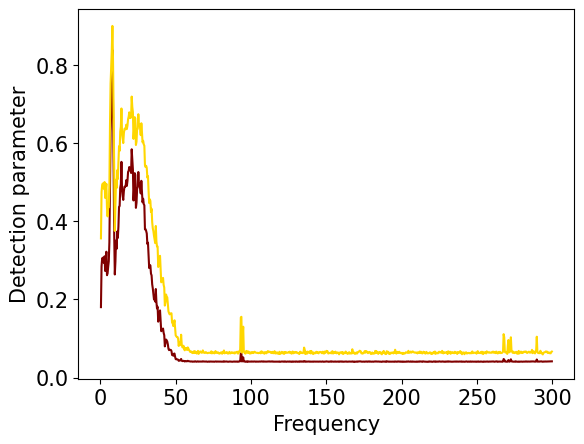

In [19]:
plt.plot(frequencies[1:last_freq_index], eig_ratios2[1:last_freq_index], color=colors[0], label="Microseismic Event")
plt.plot(frequencies[1:last_freq_index], eig_ratios_svd2[1:last_freq_index], color=colors[1], label="Noise")
# plt.plot(frequencies[1:last_freq_index], eig_ratios[1:last_freq_index], color=colors[0], label="Noise")
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.legend(fontsize=fsize)

$$\text{Detection parameter} = \frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

NameError: name 'eig_ratios' is not defined

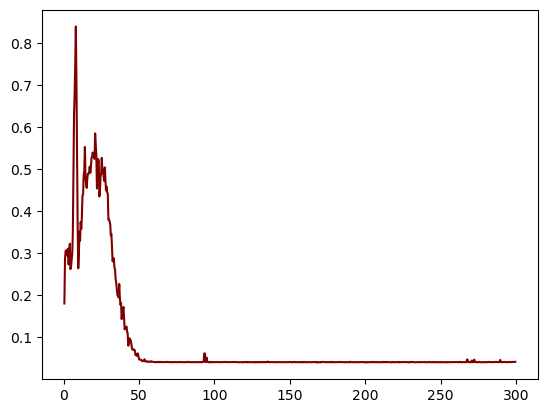

In [20]:
last_freq_index = 750
tick_size = 12
plt.plot(frequencies[1:last_freq_index], eig_ratios2[1:last_freq_index], color=colors[0], label="Microseismic Event")
plt.plot(frequencies[1:last_freq_index], eig_ratios[1:last_freq_index], color=colors[-1], alpha=0.9 , label="Background Noise")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

In [ ]:
last_freq_index = 750
tick_size = 12
plt.plot(frequencies[1:last_freq_index], eig_ratios_qr[1:last_freq_index], color="goldenrod", label="Background Noise")
plt.plot(frequencies[1:last_freq_index], eig_ratios_qr2[1:last_freq_index], color="darkviolet", alpha=0.5 , label="Microseismic Event")
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

: 

In [ ]:

avg_eigs = np.mean(eig_ratios[1:].reshape((125,10)), axis=1)
avg_eigs2 = np.mean(eig_ratios2[1:].reshape((125,10)), axis=1)
avg_freq = np.linspace(1,499,125)

plt.plot(avg_freq, avg_eigs, label="background noise")
plt.plot(avg_freq, avg_eigs2, label="microsiesmic event")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=tick_size)


: 

### Plot data

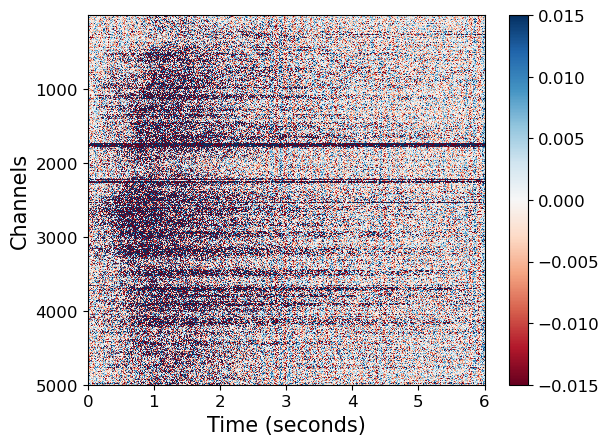

In [115]:
fsize=15
tick_size = 12
ch_start = 1
# pdata = data[start_ch:nchannels+start_ch, 47000:54000]
# pdata = data[start_ch+int(nchannels/2):nchannels*2+start_ch, 47000:53000]
pdata = data[3000:8000, 47240:53256]
# templateSamples=[17240, 23256]

# v_min = -np.percentile(np.absolute(pdata),95)
# v_max = np.percentile(np.absolute(pdata),95)
v_min = -0.015
v_max = 0.015

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none',
           extent=(0,6, 5000, 1))
         #   extent=(0,len(pdata[0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

([], [])

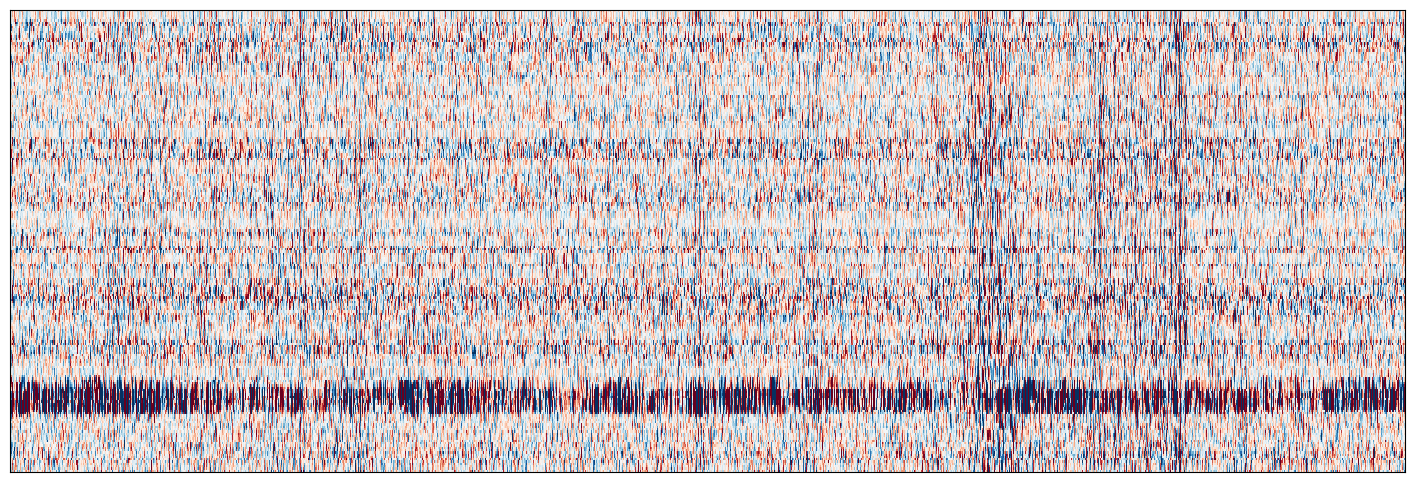

In [70]:
# plt.figure(figsize=(6,12))
fsize=15
tick_size = 12
ch_start = 1
# pdata = data[start_ch:nchannels+start_ch]
pdata = data[start_ch:200+start_ch]

# v_min = -np.percentile(np.absolute(pdata),95)
# v_max = np.percentile(np.absolute(pdata),95)
v_min = -0.015
v_max = 0.015

fig2 = plt.figure(figsize=(18,6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none')
        #    extent=(0,len(pdata[0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))

# plt.xlabel('Time (seconds)',fontsize=fsize)
# plt.ylabel('Sensors',fontsize=fsize)
# plt.title('Signal',fontsize=fsize)
plt.xticks([])
tick_loc = 2500
# plt.plot([tick_loc, tick_loc], [0, 200], linewidth=3)
plt.yticks([])
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=tick_size)

# for a in range(1, int(len(data[1])/(win_len * samples_per_sec))):
#     tick_loc = a *  win_len * samples_per_sec
#     plt.plot([tick_loc, tick_loc], [0, 200], 'r', linewidth=3)

In [59]:
len(data[1])/(2.5 * samples_per_sec)

28.0

In [78]:
frequencies[190]

76.0

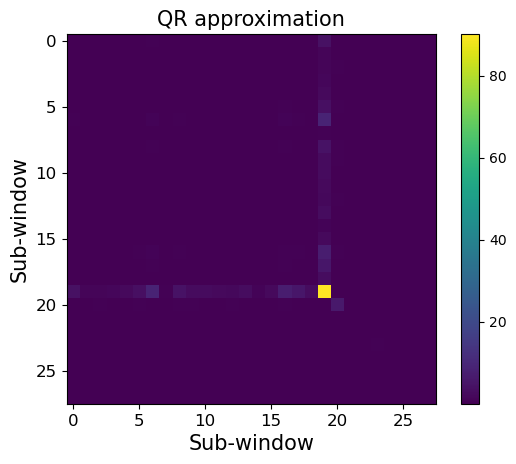

In [91]:
RandA = norm_win_spectra2[39,:,:]**2
Q1,R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1@R1.T))
plt.ylabel('Sub-window', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,3,3)

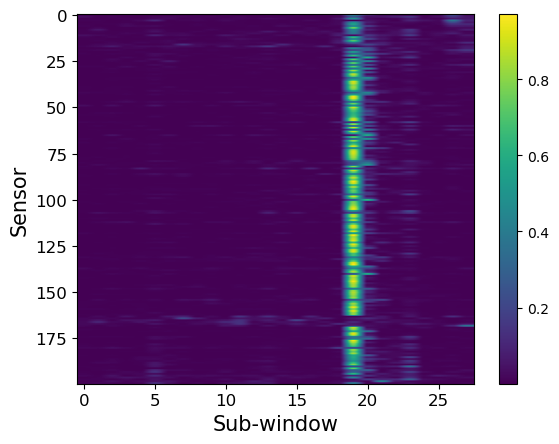

In [92]:
plt.imshow(np.abs(RandA), aspect='auto')
plt.ylabel('Sensor', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
# plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

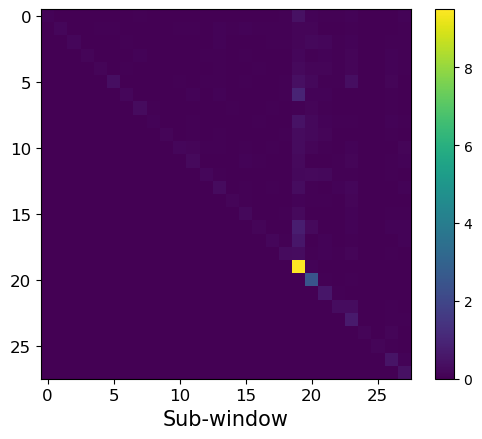

In [93]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
# plt.title('R Matrix', fontsize=15)
# plt.ylabel('Sub-window', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,2,2)
# plt.plot(frequencies)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

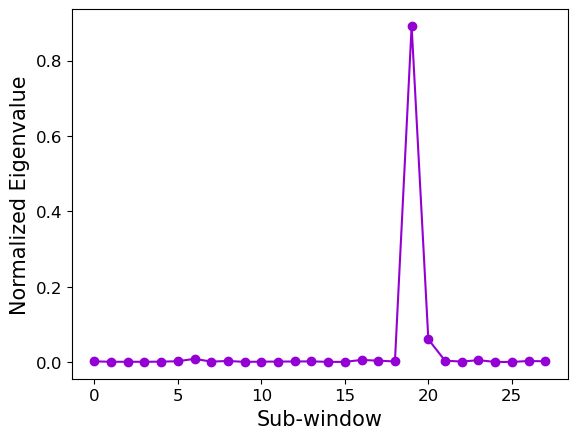

In [94]:
qr_ = np.diag(np.absolute(R1@R1.transpose()))
plt.plot(qr_/np.sum(qr_), '-o', color="darkviolet")
plt.ylabel('Normalized Eigenvalue', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title('QR Approximation of Eigenvalues', fontsize=15)
# print(np.max(qr_)/np.sum(np.absolute(qr_)))

In [ ]:
AA = 0
for a in range(1,101):
    AA += round(1/a,2)
    AA = round(AA,2)
    if round(1/a,2) > 1/a:
        AA -= 0.01
    # print(AA)
AA

4.82

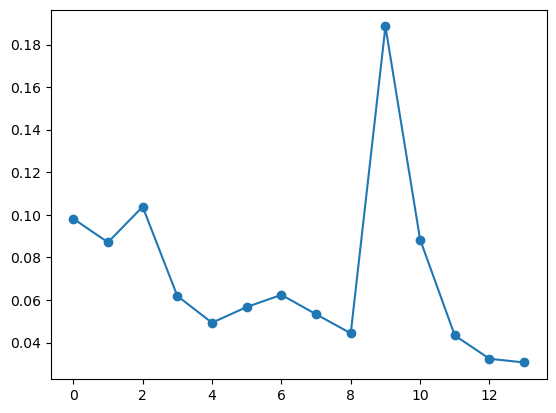

In [ ]:
# plt.plot(np.abs(R1)[9], '-o')
# plt.plot(np.abs(R1@R1.T)[9], '-o')
# R1[-1]
appr = np.sum(np.abs(R1), axis=1)
plt.plot(appr/np.sum(appr), '-o')
